# Preprocessing: Data fusion
This notebook analyzes data collected from CoTrack (Audio and Logs) with the collaboration labels (Annotated by two raters, with cohen's kappa > substantial agreement)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import seaborn as sns
import math

from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

In [2]:


# Logs and Audio features (e.g. speaking time, speaking sequence, number of chars added or deleted)
features = pd.read_csv('sch1_group-1.csv')


# Logs and Audio features for group-2
features2 = pd.read_csv('sch1_group-2.csv')


In [3]:

# Collaboration labels for group-1
labels = pd.read_csv('coder2final.csv')


# Collaboration labels for group-2
labels2 = pd.read_csv('sch1_group-2_collaboration_scores.csv')



In [4]:
#print('Number of frames (30 sec each) for group-1:',features.shape[0],labels.shape[0])
#print('Number of frames (30 sec each) for group-2:',features2.shape[0],labels2.shape[0])
print('Total number of frames (30 sec):',(features2.shape[0]+features.shape[0]))
#features[['u1_add', 'u1_del', 'u2_add', 'u2_del','u3_add', 'u3_del', 'u4_add', 'u4_del', 'u1_speak', 'u2_speak', 'u3_speak','u4_speak']]

Total number of frames (30 sec): 121


## Computing Final Collaboration Scores

In [5]:
def computeFinalScore(rater1):
    rater1['ITO'] = (rater1['u1'] + rater1['u2'] + rater1['u3'] + rater1['u4'])/4
    rater1['final'] = 0
    for dim in ['SMU','CF','KE','ARG','STR','CO','ITO']:
        rater1['final'] = rater1['final'] + rater1[dim]
    return rater1['final']

In [6]:
labels['final'] = computeFinalScore(labels)
labels2['final'] = computeFinalScore(labels2)

total_collab = pd.concat([labels,labels2],axis=0,ignore_index=True)
total_collab.columns

Index(['ARG', 'CF', 'CO', 'ITO', 'KE', 'SMU', 'STR', 'end', 'final', 'frame',
       'notes', 'start', 'u1', 'u2', 'u3', 'u4'],
      dtype='object')

In [7]:
final_labels = total_collab[['ARG','CF','CO','ITO','KE','SMU','STR','final']]
y = final_labels['final']

### Distribution of Collaboration Scores

Text(0.5, 1.0, 'Distibution of Collaboration Scores for both groups ')

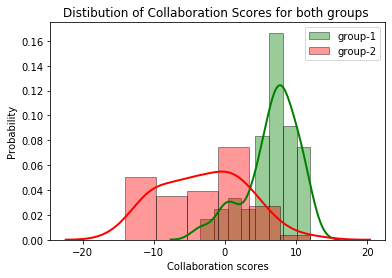

In [14]:
# Density Plot of Collboration Scores
plt.figure()
sns.distplot(labels['final'], hist=True, kde=True,  color = 'green', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 2},label="group-1")
sns.distplot(labels2['final'], hist=True, kde=True,  color = 'red', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 2},label="group-2")
plt.xlabel('Collaboration scores')
plt.ylabel('Probability')
plt.legend()
plt.title('Distibution of Collaboration Scores for both groups ')

## Computing group-level features
We have used three fusion techniques for mapping collected individual data into group-level measures. These techniques are 
 * Entropy based fusion
 * Dimensionality reduction fusion
 * Average based 
 
 Smith et al. [1] used Entropy-based fusion (Shanon entropy) to compute group-level features from individual features (30s time window).

### Entropy-based fusion
We computed three features at group-level (e.g., speaking time, characters added, and deleted) using Shanon Entropy.

In [6]:
# Computing Shanon Entropy for group-level features: Group-1

NO_USERS=4

features['group-speak'] = 0
features['group-no-speak'] = 30 - (features['u1_speak'] + features['u2_speak'] + features['u3_speak'] + features['u4_speak'])
features['group-add'] = 0
features['group-del'] = 0

for i in range(features.shape[0]):
    total_speak = features['u1_speak'] + features['u2_speak'] + features['u3_speak'] + features['u4_speak']
    total_add = features['u1_add'] + features['u2_add'] + features['u3_add'] + features['u4_add']
    total_del = features['u1_del'] + features['u2_del'] + features['u3_del'] + features['u4_del']
    
    entropy_spk = 0.0
    entropy_add = 0.0
    entropy_del = 0.0
    

    
    for j in range(NO_USERS):
        col_speak = 'u{}_speak'.format(str(j+1))
        col_add = 'u{}_add'.format(str(j+1))
        col_del = 'u{}_del'.format(str(j+1))
        
        
        
        
        
        # Entropy-based fusion
        
        if features.loc[i,col_speak] == 0:
            entropy_spk = entropy_spk + 0
        else:
            prob_spk = features.loc[i,col_speak]/(1.0*total_speak[i])
            entropy_spk = entropy_spk + prob_spk * math.log(1/prob_spk,2)
        
        if features.loc[i,col_add] == 0:
            entropy_add = entropy_add + 0
        else:
            prob_add = features.loc[i,col_add]/(1.0*total_add[i])
            entropy_add = entropy_add + prob_add * math.log(1/prob_add,2)
        
        if features.loc[i,col_del] == 0:
            entropy_del = entropy_del + 0
        else:
            prob_del = features.loc[i,col_del]/(1.0*total_del[i])
            entropy_del = entropy_del + prob_del * math.log(1/prob_del,2)

        
        
        
    features.loc[i,'group-speak'] = entropy_spk
    features.loc[i,'group-add'] = entropy_add
    features.loc[i,'group-del'] = entropy_del

In [7]:
# Computing Shanon Entropy for group-level features: Group-2

NO_USERS=4

features2['group-no-speak'] = 30 - (features2['u1_speak'] + features2['u2_speak'] + features2['u3_speak'] + features2['u4_speak'])
features2['group-speak'] = 0
features2['group-add'] = 0
features2['group-del'] = 0

for i in range(features2.shape[0]):
    total_speak = features2['u1_speak'] + features2['u2_speak'] + features2['u3_speak'] + features2['u4_speak']
    total_add = features2['u1_add'] + features2['u2_add'] + features2['u3_add'] + features2['u4_add']
    total_del = features2['u1_del'] + features2['u2_del'] + features2['u3_del'] + features2['u4_del']
    
    entropy_spk = 0.0
    entropy_add = 0.0
    entropy_del = 0.0
    

    
    for j in range(NO_USERS):
        col_speak = 'u{}_speak'.format(str(j+1))
        col_add = 'u{}_add'.format(str(j+1))
        col_del = 'u{}_del'.format(str(j+1))
        
        
        
        
        
        # Entropy-based fusion
        
        if features2.loc[i,col_speak] == 0:
            entropy_spk = entropy_spk + 0
        else:
            prob_spk = features2.loc[i,col_speak]/(1.0*total_speak[i])
            entropy_spk = entropy_spk + prob_spk * math.log(1/prob_spk,2)
        
        if features2.loc[i,col_add] == 0:
            entropy_add = entropy_add + 0
        else:
            prob_add = features2.loc[i,col_add]/(1.0*total_add[i])
            entropy_add = entropy_add + prob_add * math.log(1/prob_add,2)
        
        if features2.loc[i,col_del] == 0:
            entropy_del = entropy_del + 0
        else:
            prob_del = features2.loc[i,col_del]/(1.0*total_del[i])
            entropy_del = entropy_del + prob_del * math.log(1/prob_del,2)

        
        
        
    features2.loc[i,'group-speak'] = entropy_spk
    features2.loc[i,'group-add'] = entropy_add
    features2.loc[i,'group-del'] = entropy_del

### Average of individual-level feature

In [8]:
# Computing average for group-level features

NO_USERS=4

features['avg_group-speak'] = (features['u1_speak'] + features['u2_speak'] + features['u3_speak'] + features['u4_speak'])/4.0

features['avg_group-add'] = (features['u1_add'] + features['u2_add'] + features['u3_add'] + features['u4_add'])/4.0
features['avg_group-del'] = (features['u1_del'] + features['u2_del'] + features['u3_del'] + features['u4_del'])/4.0

# Group-2
features2['avg_group-speak'] = (features2['u1_speak'] + features2['u2_speak'] + features2['u3_speak'] + features2['u4_speak'])/4.0

features2['avg_group-add'] = (features2['u1_add'] + features2['u2_add'] + features2['u3_add'] + features2['u4_add'])/4.0
features2['avg_group-del'] = (features2['u1_del'] + features2['u2_del'] + features2['u3_del'] + features2['u4_del'])/4.0




A1 = pd.concat([features['avg_group-speak'],features['avg_group-add'],features['avg_group-del']], axis=1)
B1 = pd.concat([features2['avg_group-speak'],features2['avg_group-add'],features2['avg_group-del']], axis=1)
X_avg = pd.concat([A1,B1])


### Dimensionality Reduction based fusion

In [9]:
from sklearn.decomposition import PCA
import numpy as np

student_features = features[[ 'u1_add', 'u1_del', 'u2_add', 'u2_del','u3_add', 'u3_del', 'u4_add', 'u4_del','u1_speak', 'u2_speak', 'u3_speak','u4_speak']]
pca = PCA(n_components=4)
pca_features = pca.fit_transform(student_features)
print('Explained Variance group-1:',pca.explained_variance_ratio_.sum())

features['pca_group_feature1'] = pca_features[:,0]
features['pca_group_feature2'] = pca_features[:,1]
features['pca_group_feature3'] = pca_features[:,2]
features['pca_group_feature4'] = pca_features[:,3]


student_features2 = features2[[ 'u1_add', 'u1_del', 'u2_add', 'u2_del','u3_add', 'u3_del', 'u4_add', 'u4_del','u1_speak', 'u2_speak', 'u3_speak','u4_speak']]
pca2 = PCA(n_components=4)
pca_features2 = pca2.fit_transform(student_features2)
print('Explained Variance group-2:',pca2.explained_variance_ratio_.sum())

features2['pca_group_feature1'] = pca_features2[:,0]
features2['pca_group_feature2'] = pca_features2[:,1]
features2['pca_group_feature3'] = pca_features2[:,2]
features2['pca_group_feature4'] = pca_features2[:,3]




X_pca = np.concatenate((pca_features,pca_features2),axis=0)


Explained Variance group-1: 0.9853168560394207
Explained Variance group-2: 0.9366498472364618


In [10]:
total_features = pd.concat([features,features2],axis=0,ignore_index=True)
csv_features = total_features[['u1_add','u1_del','u1_speak','u2_add','u2_del','u2_speak','u3_add','u3_del','u3_speak','u4_add','u4_del','u4_speak','group-no-speak','group-add','group-del','group-speak','avg_group-add','avg_group-del','avg_group-speak','pca_group_feature1','pca_group_feature2','pca_group_feature3','pca_group_feature4']]

csv_features.to_csv('features.csv',index=False)



## Preparing data for machine learning algorithms

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import metrics

In [22]:
# Adding features and collaboration labels from both groups

A = pd.concat([features['group-speak'],features['group-add'],features['group-del']], axis=1)
B = pd.concat([features2['group-speak'],features2['group-add'],features2['group-del']], axis=1)
X_ent = pd.concat([A,B])

## Exploring Regression with different fusion approaches

In [29]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import librosa
import seaborn as sns
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, Lars, BayesianRidge, SGDRegressor, RANSACRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor


In [58]:

def exploreRegression(X,y,label):
    seed = 40
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)
    
    svm = SVR(C=50,gamma=.1,kernel='rbf')
    knn = KNeighborsRegressor(n_neighbors=5)
    rf =  RandomForestRegressor(n_estimators=50,max_depth=2,min_samples_split=5,random_state=seed)

    ab = AdaBoostRegressor(n_estimators=100,learning_rate=.001,loss='linear',random_state=seed)
    gb = GradientBoostingRegressor(n_estimators=100,learning_rate=.001,loss='lad',min_samples_split=3,random_state=seed)
    xgb = XGBRegressor(booster='gbtree',max_depth=2,random_state=seed)

   



    voting = VotingRegressor([('knn',knn),('ada',ab),('rand',rf)])
    mlp = MLPRegressor(activation='tanh',hidden_layer_sizes=(5,5),solver='lbfgs')

    regression_models = [svm,knn,rf,ab,gb,xgb,voting,mlp]
    regression_labels = ['SVM','KNN','Random Forest','Adaboost Regressor','Gradient Boost Regressor','XGB Regressor','Voting','Neural Net']

    print('#'*50)
    print('                Performance on ',label)
    print('#'*50)
    for i in range(len(regression_models)):
        regression_models[i].fit(X_train,y_train)
        #print(regression_labels[i],' Train:   RMSE->',mean_squared_error(y_train,regression_models[i].predict(X_train),squared=False),'MAE->',mean_absolute_error(y_train,regression_models[i].predict(X_train)))

        print(regression_labels[i],' Test:  RMSE->',mean_squared_error(y_test,regression_models[i].predict(X_test),squared=False),'MAE->',mean_absolute_error(y_test,regression_models[i].predict(X_test)))


In [62]:
exploreRegression(X_ent,y,'Entropy-based Fusion')

##################################################
                Performance on  Entropy-based Fusion
##################################################
SVM  Test:  RMSE-> 7.135464118051081 MAE-> 5.604670177470271
KNN  Test:  RMSE-> 7.391521805054395 MAE-> 6.062162162162162
Random Forest  Test:  RMSE-> 6.530261023243199 MAE-> 5.352692186299678
Adaboost Regressor  Test:  RMSE-> 7.833311461030371 MAE-> 6.185983982424342
Gradient Boost Regressor  Test:  RMSE-> 6.5909384760413445 MAE-> 5.456603053999929
[21:22:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB Regressor  Test:  RMSE-> 8.16614787005538 MAE-> 6.266705199673369
Voting  Test:  RMSE-> 7.065916671795648 MAE-> 5.77551456054959
Neural Net  Test:  RMSE-> 7.17007687815274 MAE-> 5.827359229290228


In [60]:
exploreRegression(X_pca,y,'PCA Fusion')

##################################################
                Performance on  PCA Fusion
##################################################
SVM  Test:  RMSE-> 4.460802482942428 MAE-> 3.5625039100410087
KNN  Test:  RMSE-> 5.099383905553319 MAE-> 4.320270270270269
Random Forest  Test:  RMSE-> 4.866205072952463 MAE-> 3.8499801238484834
Adaboost Regressor  Test:  RMSE-> 5.265175485797224 MAE-> 3.9771381786548567
Gradient Boost Regressor  Test:  RMSE-> 6.3454457767955414 MAE-> 5.197486215717995
[21:19:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB Regressor  Test:  RMSE-> 5.763575650108265 MAE-> 4.466041300747846
Voting  Test:  RMSE-> 4.841185319867135 MAE-> 3.9036382891804275
Neural Net  Test:  RMSE-> 6.002752498846212 MAE-> 4.877874595185446


In [61]:
exploreRegression(X_avg,y,'Average Fusion')

##################################################
                Performance on  Average Fusion
##################################################
SVM  Test:  RMSE-> 7.12162539066774 MAE-> 5.952793540836933
KNN  Test:  RMSE-> 7.687190995767271 MAE-> 6.101351351351352
Random Forest  Test:  RMSE-> 7.480024731693995 MAE-> 5.685620391706585
Adaboost Regressor  Test:  RMSE-> 7.65730747305164 MAE-> 5.931441045355522
Gradient Boost Regressor  Test:  RMSE-> 6.5687315674266475 MAE-> 5.332139014451139
[21:19:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB Regressor  Test:  RMSE-> 7.82322918535106 MAE-> 5.942637429849522
Voting  Test:  RMSE-> 7.474839216091283 MAE-> 5.775791926878182
Neural Net  Test:  RMSE-> 8.3673349237842 MAE-> 6.835104476901599


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 576x360 with 0 Axes>

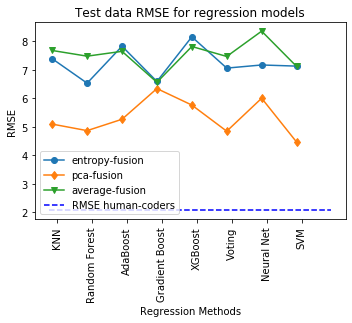

In [25]:
import numpy as np
plt.figure(figsize=(8,5))
ent_error = [7.39,6.53,7.83,6.59,8.16,7.06,7.17,7.13]
pca_error = [5.09,4.86,5.26,6.34,5.76,4.84,6,4.46]
avg_error = [7.68,7.48,7.65,6.56,7.82,7.47,8.36,7.12]
x_label=['KNN','Random Forest','AdaBoost','Gradient Boost','XGBoost','Voting','Neural Net','SVM']

x = np.arange(len(x_label))
w=.3

fig, ax = plt.subplots()
fig.set_figheight(4.6)
fig.set_figwidth(5)

ax.set_xticks(x+w/2)
ax.set_xticklabels(x_label,rotation=90)




ax.plot(x,ent_error,label='entropy-fusion',marker='o')
ax.plot(x,pca_error,label='pca-fusion',marker='d')
ax.plot(x,avg_error,label='average-fusion',marker='v')

ax.set_ylabel('RMSE')
ax.set_xlabel('Regression Methods')

ax.hlines(2.06,-0.1,8,color='blue',linestyles='dashed',label='RMSE human-coders')
ax.set_title('Test data RMSE for regression models')
ax.legend()
fig.tight_layout()
plt.savefig('fusion.eps')